In [203]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
#import PIL
import pathlib
from tensorflow import keras
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D ,BatchNormalization

In [143]:
train_path = r'C:\Users\nnadi\Downloads\Cancer\skin-lesions\train'
test_path = r'C:\Users\nnadi\Downloads\Cancer\skin-lesions\test'
valid_path = r'C:\Users\nnadi\Downloads\Cancer\skin-lesions\valid'

In [144]:
batch_size = 32
img_height = 180
img_width =180
batch = 32
epochs = 40
channels = 3

In [181]:
#train_data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2000 files belonging to 3 classes.


In [193]:
train_ds.class_names
classes = train_ds.class_names

In [147]:
# test_data 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    shuffle =True ,
    image_size =(img_height,img_width)  , # image_size = (180,180,3)
    batch_size = batch_size             # 32
)

Found 150 files belonging to 3 classes.


In [148]:
val_ds.class_names

['melanoma', 'nevus', 'seborrheic_keratosis']

In [149]:
for image_batch , lable_batch in val_ds.take(1) :
    print('this is one batch shape :',image_batch.shape)  # (batch_size,img_height,img_width,chanells)  
    print('this is lable shape :',lable_batch.shape)

this is one batch shape : (32, 180, 180, 3)
this is lable shape : (32,)


In [150]:
class_names = train_ds.class_names
n_classes = len(class_names)
print(class_names, n_classes)

['melanoma', 'nevus', 'seborrheic_keratosis'] 3


<BarContainer object of 3 artists>

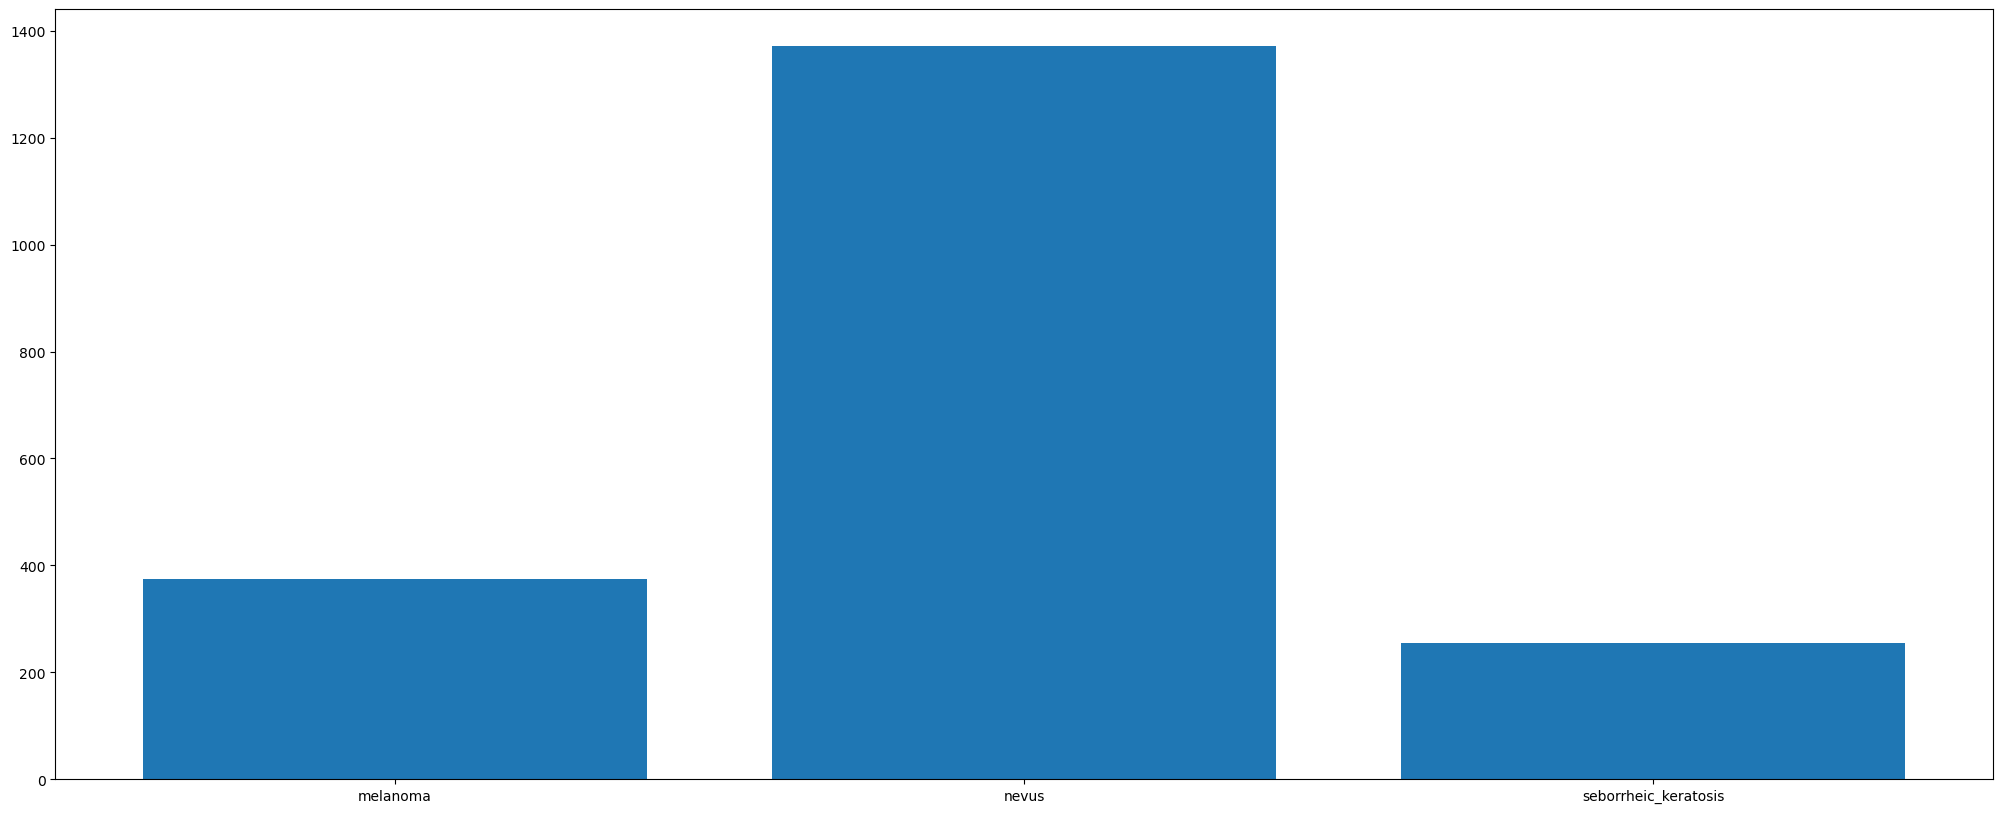

In [151]:
data_dir_train = pathlib.Path(r"C:\Users\nnadi\Downloads\Cancer\skin-lesions\train")

#plot number of images in each Class
count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'/*.jpg'))))

plt.figure(figsize=(25,10))
plt.bar(class_names,count)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

<BarContainer object of 3 artists>

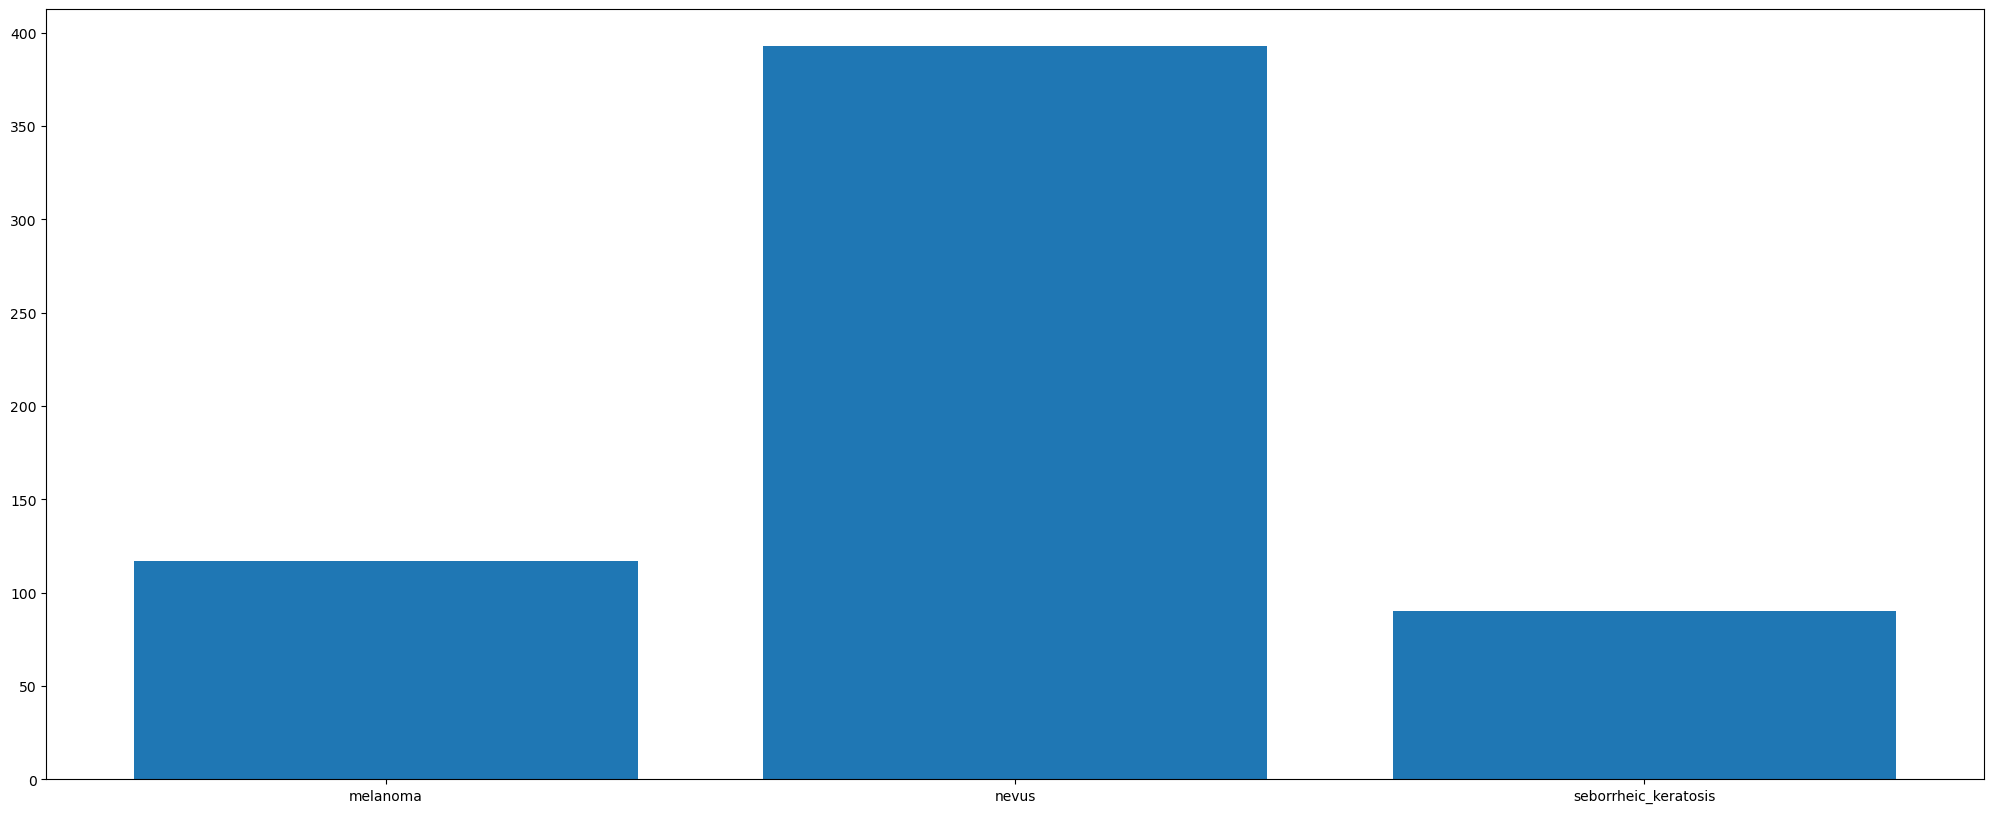

In [152]:
data_dir_train = pathlib.Path(r"C:\Users\nnadi\Downloads\Cancer\skin-lesions\test")

#plot number of images in each Class
count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

<BarContainer object of 3 artists>

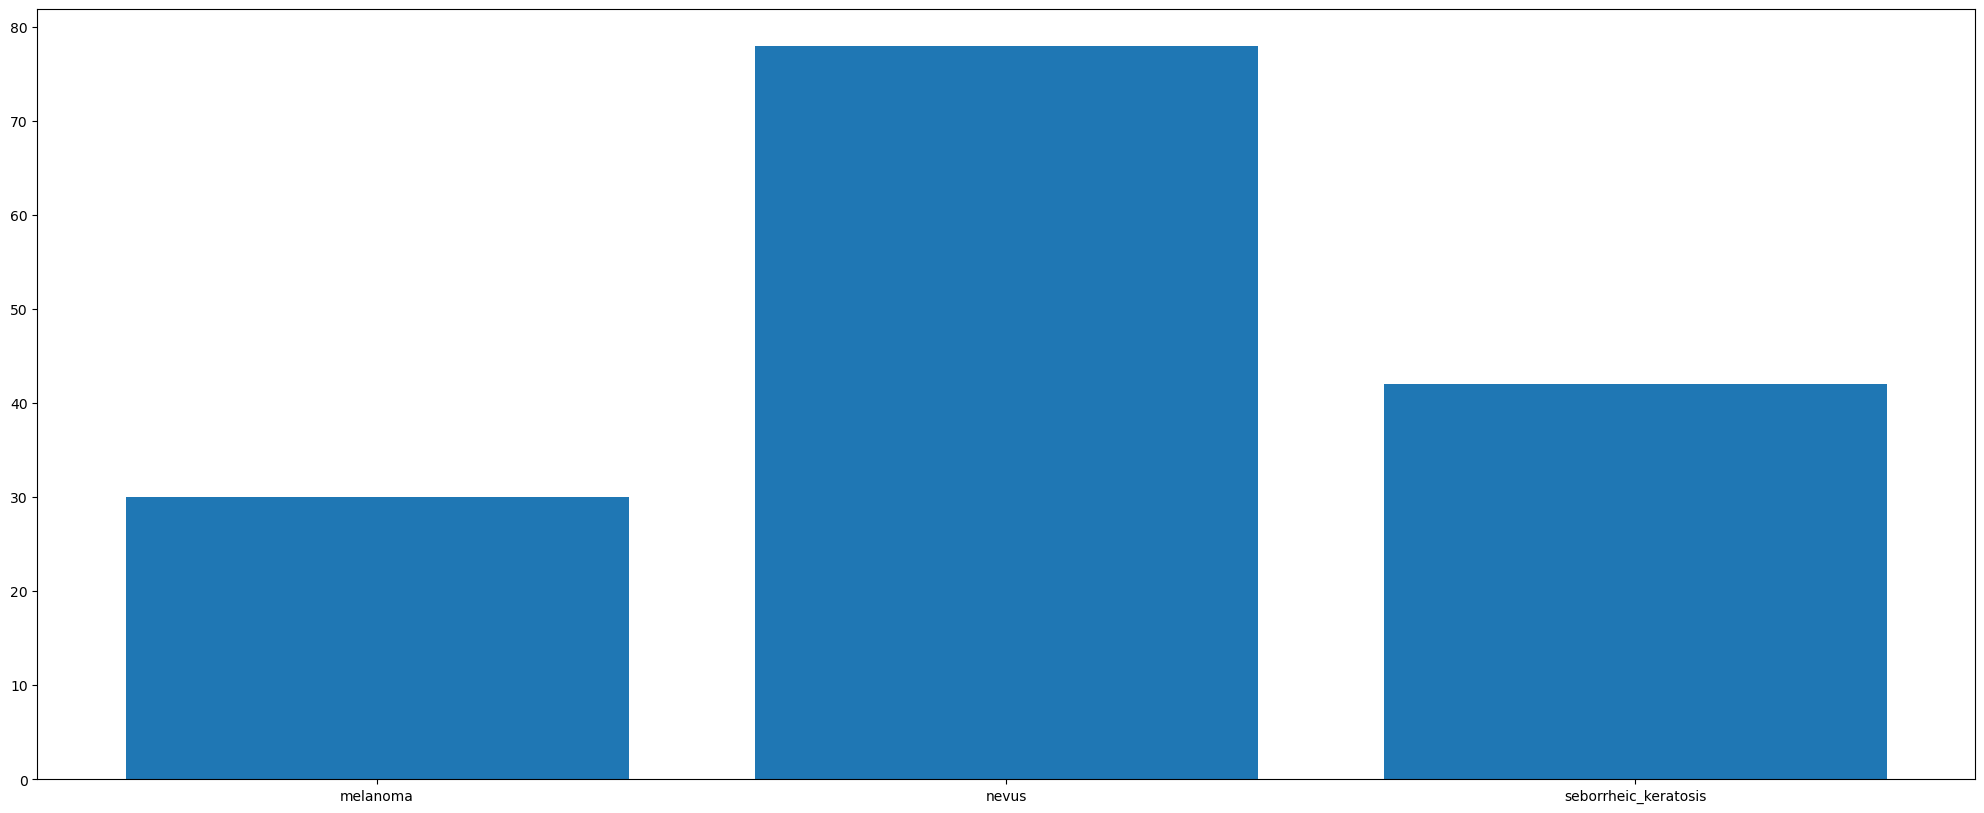

In [153]:
data_dir_train = pathlib.Path(r"C:\Users\nnadi\Downloads\Cancer\skin-lesions\valid")

#plot images in each Class
count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

(32, 180, 180, 3)
[1 0 1 1 1 1 1 2 0 1 0 1 1 1 2 1 2 0 0 0 1 1 1 1 1 1 1 1 2 1 0 1]


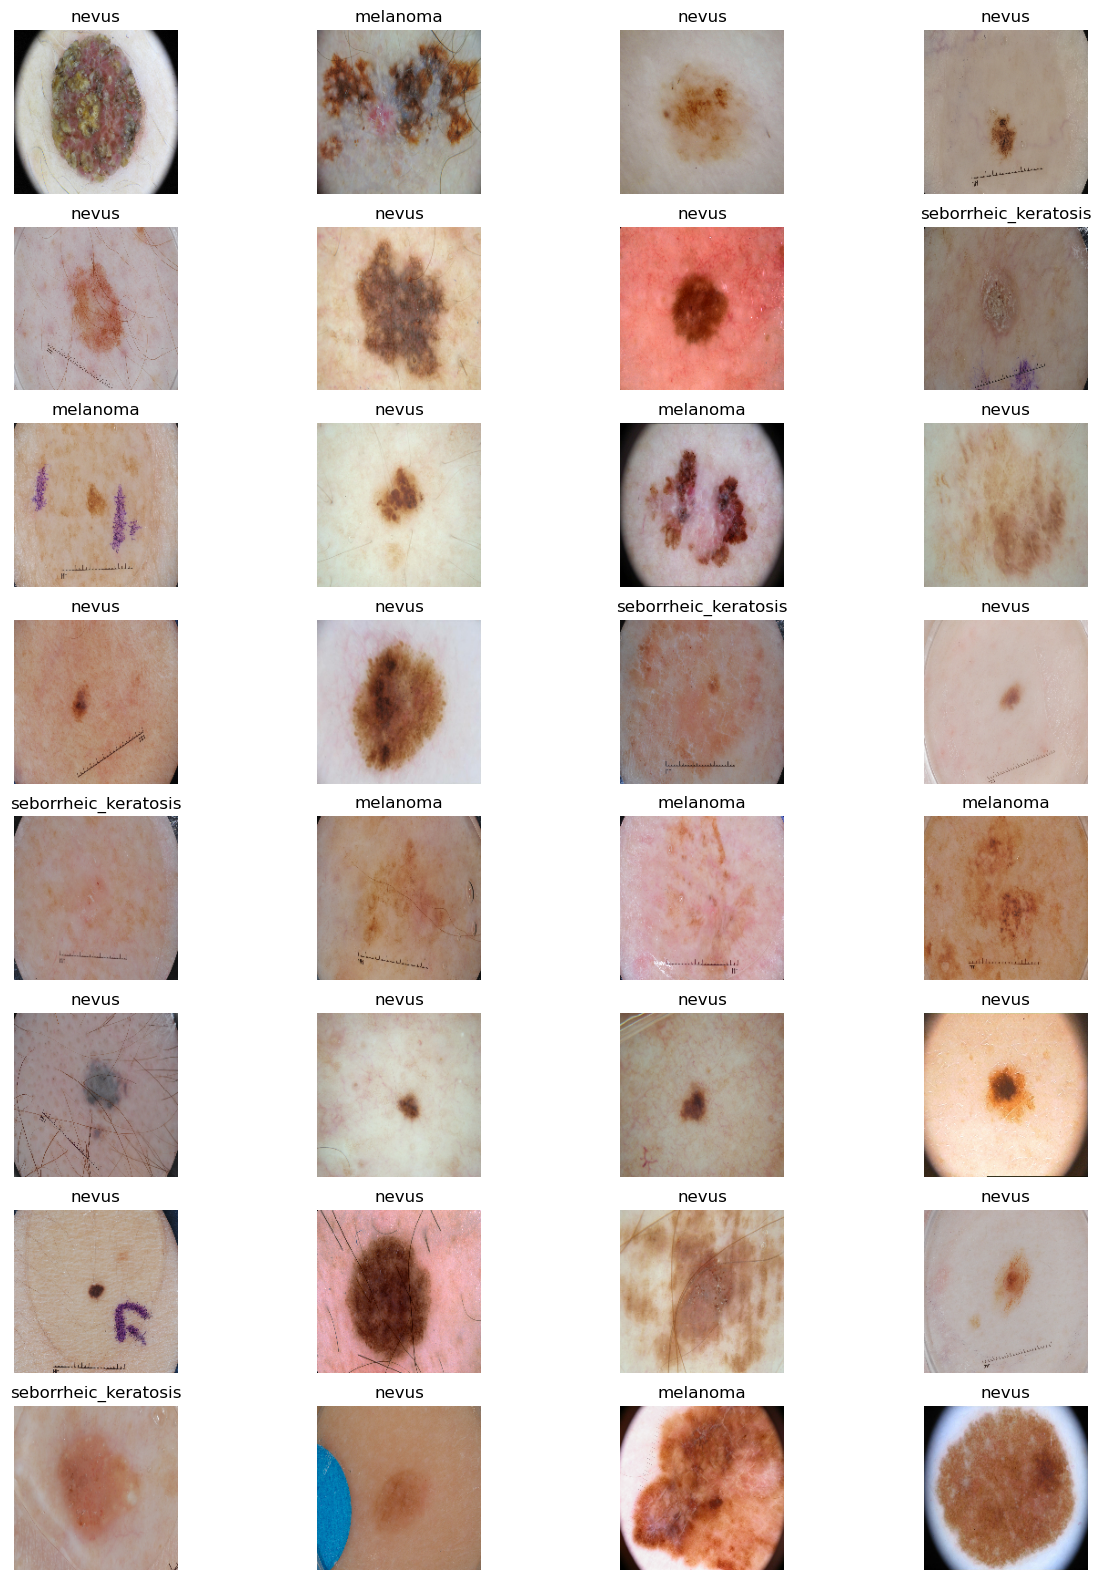

In [154]:
plt.figure(figsize=(15,20))

for image_batch , labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(batch_size):
        plt.subplot(8,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [155]:
# increases the perfomance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [156]:

resize_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

resize_rescale model dedicated to take input images, resize them to the specified dimensions, and then scale their pixel values to the range [0, 1].

In [157]:
data_augmentating = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)
])

data_augmentating model is designed for data augmentation, used in training deep learning models to improve their generalization and robustness. It introduces variability in the training data by applying random transformations, which helps the model become more invariant to such variations during testing.

In [158]:
input_shapened = (batch_size , img_height , img_width , channels)

In [121]:
# Define the ImageDataGenerator for validation data (only rescaling, no augmentation)
#validation_datagen = ImageDataGenerator(rescale=1./255)

In [125]:
# Create the generators
#train_generator = train_datagen.flow_from_directory(
#    train_path,
#    target_size=(180, 180),  # Adjust size as needed
#    batch_size=batch_size,
#    class_mode='categorical',  # Use 'categorical' if you have more than two classes
#)

#validation_generator = validation_datagen.flow_from_directory(
#    valid_path,
#    target_size=(180, 180),  # Adjust size as needed
#    batch_size=batch_size,
#    class_mode='categorical',  # Use 'categorical' if you have more than two classes
#)


# create CNN model

model = Sequential()

model.add(resize_and_rescale)
model.add(data_augmentation)

model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',input_shape=input_shape))
model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(n_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.build(input_shape)

In [166]:
from tensorflow.keras import models
from tensorflow.keras import layers


model = models.Sequential([
    resize_rescale,
    data_augmentating,
    layers.Conv2D(filters = 64, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1),input_shape = input_shapened),
    layers.Conv2D(filters = 64, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(filters = 128, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 128, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(filters = 256, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 256, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),

    layers.MaxPooling2D(2,2),
    layers.Conv2D(filters = 512, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 512, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),

    layers.MaxPooling2D(2,2),
    layers.Conv2D(filters = 512, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),
    layers.Conv2D(filters = 512, kernel_size =(3,3),activation = "relu", padding = 'same',strides = (1,1)),

    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(4096,activation = 'relu'),
    layers.Dense(4096,activation = 'relu'),
    layers.Dense(1000,activation = 'relu'),
    layers.Dense(len(classes),activation = 'softmax')
])

model.build(input_shape=input_shapened)

In [167]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (32, 180, 180, 64)        1792      
_________________________________________________________________
conv2d_49 (Conv2D)           (32, 180, 180, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (32, 90, 90, 64)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (32, 90, 90, 128)         73856     
_________________________________________________________________
conv2d_51 (Conv2D)           (32, 90, 90, 128)       

In [168]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor= 'loss', patience=5,mode = 'min' ,verbose=1)

This setup is useful for preventing overfitting. If the loss on the training set stops decreasing and starts to increase (indicating potential overfitting), the training will be stopped early.

In [169]:

CNN = model.fit(
    train_ds,
    shuffle = True,
    epochs = epochs,
    batch_size = batch,
    verbose = 2,
    validation_data = val_ds
)


Epoch 1/40
63/63 - 310s - loss: 0.9926 - accuracy: 0.6695 - val_loss: 1.1478 - val_accuracy: 0.5200
Epoch 2/40
63/63 - 313s - loss: 0.8473 - accuracy: 0.6860 - val_loss: 1.1639 - val_accuracy: 0.5200
Epoch 3/40
63/63 - 299s - loss: 0.8424 - accuracy: 0.6860 - val_loss: 1.1020 - val_accuracy: 0.5200
Epoch 4/40
63/63 - 303s - loss: 0.8402 - accuracy: 0.6860 - val_loss: 1.0751 - val_accuracy: 0.5200
Epoch 5/40
63/63 - 301s - loss: 0.8384 - accuracy: 0.6860 - val_loss: 1.0857 - val_accuracy: 0.5200
Epoch 6/40
63/63 - 300s - loss: 0.8374 - accuracy: 0.6860 - val_loss: 1.1000 - val_accuracy: 0.5200
Epoch 7/40
63/63 - 303s - loss: 0.8446 - accuracy: 0.6860 - val_loss: 1.0710 - val_accuracy: 0.5200
Epoch 8/40
63/63 - 303s - loss: 0.8371 - accuracy: 0.6860 - val_loss: 1.1257 - val_accuracy: 0.5200
Epoch 9/40
63/63 - 317s - loss: 0.8352 - accuracy: 0.6860 - val_loss: 1.0657 - val_accuracy: 0.5200
Epoch 10/40
63/63 - 310s - loss: 0.8446 - accuracy: 0.6860 - val_loss: 1.1814 - val_accuracy: 0.5200

In [23]:
#model.summary()

In [170]:
#cnn = model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=10)

In [171]:
CNN.history['accuracy']

[0.6694999933242798,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825,
 0.6859999895095825]

In [172]:
CNN.history['val_accuracy']

[0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137,
 0.5199999809265137]

In [173]:
CNN.history['loss']

[0.9925636053085327,
 0.8472809791564941,
 0.8423684239387512,
 0.8402127027511597,
 0.8384401202201843,
 0.8374036550521851,
 0.8445669412612915,
 0.8371484875679016,
 0.8352147340774536,
 0.8446286916732788,
 0.8385275602340698,
 0.8389413356781006,
 0.8372132182121277,
 0.8362638354301453,
 0.8396762013435364,
 0.8367388844490051,
 0.8376709818840027,
 0.8376104235649109,
 0.8371456861495972,
 0.8363748788833618,
 0.8390465974807739,
 0.8359684348106384,
 0.8368422985076904,
 0.8359471559524536,
 0.8369259238243103,
 0.8383357524871826,
 0.8371990323066711,
 0.8398224115371704,
 0.8385456204414368,
 0.8403341174125671,
 0.834816575050354,
 0.8347507119178772,
 0.8367906212806702,
 0.8373056054115295,
 0.8376085758209229,
 0.8375933766365051,
 0.8358433842658997,
 0.8348947167396545,
 0.8358964920043945,
 0.8380042910575867]

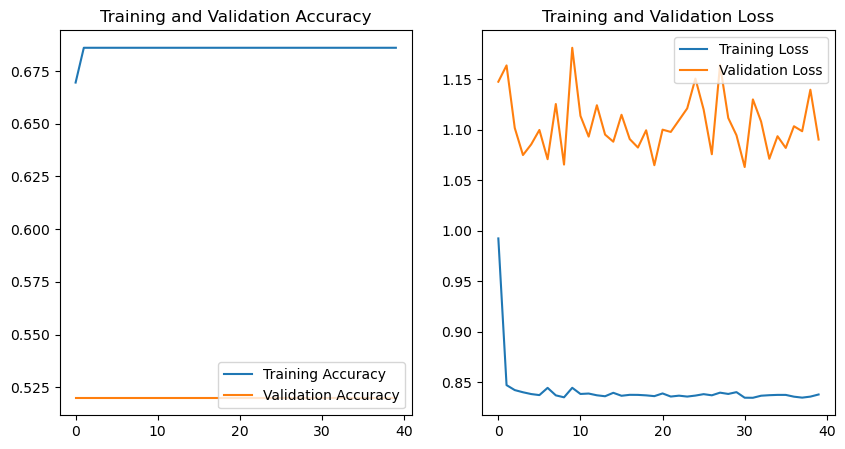

In [179]:
acc = CNN.history['accuracy']
val_acc = CNN.history['val_accuracy']

loss = CNN.history['loss']
val_loss = CNN.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [183]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 600 files belonging to 3 classes.


In [184]:
model.evaluate(test_ds)

19/19 [==============================] - 60s 3s/step - loss: 0.8815 - accuracy: 0.6550


[0.8814927935600281, 0.6549999713897705]

In [ ]:

Y_pred = model.predict(test_ds)
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
classes_np = np.array(classes)

print(len(classes_np), len(Y_pred))

In [ ]:
print(classification_report(classes_np, Y_pred))

In [198]:
import seaborn as sns
import matplotlib
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)


Seaborn version: 0.12.2
Matplotlib version: 3.4.3
